# Problem4
In this problem we will be achieving large-batch SGD using batch augmentation techniques. In batch augmentation instances of samples within the same batch are generated with different data augmentations. Batch augmentation acts as a regularizer and an accelerator, increasing both generalization and performance scaling. One such augmentation scheme is using Cutout regularization, where additional samples are generated by occluding random portions of an image.

# 1
Explain cutout regularization and its advantages compared to simple dropout (as argued in the paper by DeVries et al) in your own words. Select any 2 images from CIFAR10 and show how does these images look after applying cutout. Use a square-shaped fixed size zero-mask to a random location of each image and generate its cutout version. Refer to the paper by DeVries et al (Section 3) and associated github repository. (2+4)

cutout regularization: cutout is an image augmentation and regularization technique that randomly masks out square regions of input during training. cutout regularization can be used to improve the robustness and overall performance of convolutional neural networks. 

Intutively, **cutout regulartization** mask out a random region of the image, which can somehow force the model to learn a more global feature rather than rely on the local feature. Such data augmentation can make the model be robust to image noise.


**simple dropout**: pixel-wise dropout (the pixel can be the feature map pixel), which is more like gaussian noise style data augmentation.

We use a figure to show the difference between simple dropout and cutout regularization.

<center><img src="./problem4/cutout.jpg" width=500></center>

In [5]:
# cifar10
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
# transform = transforms.ToTensor()
# cutoff transform

dataset = CIFAR10(root='./cached_datasets/CIFAR10', train=True, download=True, transform=None)

Files already downloaded and verified


#### Display

<Figure size 1440x1440 with 0 Axes>

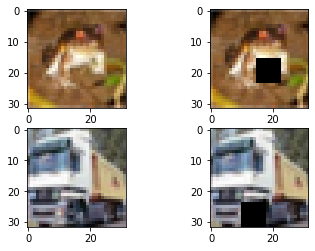

In [37]:
import albumentations as A
import PIL
import numpy as np
import cv2

import matplotlib.pyplot as plt
transform = A.Cutout(num_holes=1, max_h_size=8, max_w_size=8, fill_value=0, always_apply=True, p=1)

# Convert the image back to OpenCV format
# transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR)
# Display the image
# plt.subplot(121)
plt.figure(figsize=(20,20))
f, axarr = plt.subplots(2,2) 

img = dataset[0][0]
image_array = np.array(img)
# Augment an image
transformed = transform(image=image_array)

transformed_image = transformed["image"]
axarr[0][0].imshow(img)
axarr[0][1].imshow(transformed_image)


img = dataset[1][0]
image_array = np.array(img)
transformed = transform(image=image_array)

transformed_image = transformed["image"]

axarr[1][0].imshow(img)
axarr[1][1].imshow(transformed_image)

## 2
Using CIFAR10 datasest and Resnet-44 we will first apply simple data augmentation as in He et al.

(look at Section 4.2 of He et al.) and train the model with batch size 64. Note that testing is always done with original images. Plot validation error vs number of training epochs. (4)

In [38]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
import torch
from models.resnet44 import resnet44
import torchvision.datasets as datasets
# from torchvision.models.resnet import resnet44
# from models.resnet import ResNet44


class ResNetLightningModule(pl.LightningModule):
    def __init__(self, batch_size=32 ,optimizer_name='SGD', aug_method="simple_aug"):
        super(ResNetLightningModule, self).__init__()
        self.model = resnet44()
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer_name = optimizer_name
        self.batch_size = batch_size
        self.aug_method = aug_method

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)

        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        logs = {'train_loss': loss}

        return {'loss': loss, 'log': logs}
    
    def on_train_epoch_end(self) -> None:
        return super().on_train_epoch_end()

    def train_dataloader(self):
        if self.aug_method == "simple_aug":
            train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),#random crop
                                        transforms.RandomHorizontalFlip(0.5),#random flip
                                        transforms.ToTensor(), #convert to tensor
                                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),#normalize
                                        ])
        else:
            train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),#random crop
                                        transforms.RandomHorizontalFlip(0.5),#random flip
                                        transforms.ToTensor(), #convert to tensor
                                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),#normalize
                                        transform])
        train_dataset = datasets.CIFAR10(root='./cached_datasets/CIFAR10', train=True, download=True, transform=train_transform)

        return torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2, pin_memory=True)

    def test_dataloader(self):
        test_transform = transforms.Compose([
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), 
            transforms.ToTensor(),])
        test_dataset = datasets.CIFAR10(root='./cached_datasets/CIFAR10', train=True, download=True, transform=test_transform)

        return torch.utils.data.DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2, pin_memory=True)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss_fn(y_hat, y)

        return {'val_loss': loss}
        
    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        logs = {'val_loss': avg_loss}

        return {'val_loss': avg_loss, 'log': logs}

    def configure_optimizers(self):
        if self.optimizer_name == 'SGD':
            # Use SGD optimizers with 0.1 as the learning rate, momentum 0.9, weight decay 5e-4.
            optimizer = torch.optim.SGD(self.parameters(), lr=0.1, weight_decay=5e-4, momentum=0.9)
        return optimizer